In [1]:
%run "../code/translator.py"
%run "../code/validation.py"

In [2]:
import re
import pickle
import numpy as np
import pandas as pd
from itertools import chain, permutations
from collections import Counter
import string
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
character_set = string.ascii_lowercase

In [4]:
def count_dict_to_freq_list(input_dict):
    # Fill a new dict with only and all the characters in our character set
    new_dict = {}
    for c in character_set:
        if c in input_dict.keys():
            new_dict[c] = input_dict[c]
        else:
            new_dict[c] = 0
            
    # Create a Dataframe from this dict and calculate the frequency along
    letter_freq_df = pd.DataFrame.from_dict(new_dict, orient='index')
    letter_freq_df.columns = ['count']
    letter_freq_df['freq'] = letter_freq_df['count'] / letter_freq_df['count'].sum()
    
    return letter_freq_df.sort_values('freq', ascending=False)

In [5]:
def process_word(original_word):
    return original_word.lower()

def is_valid_word(word):
    # Check if letters in character_set
    valid_word = True
    for letter in list(word):
        if letter not in character_set:
            valid_word = False
            
    return valid_word

In [6]:
import unittest

class Testjes(unittest.TestCase):

    def test_process_word(self):
        test_word = "Nederland"
        self.assertEqual('nederland', process_word(test_word))
        
    def test_check_valid_word(self):
        self.assertTrue(is_valid_word('nederland'))
        
suite = unittest.TestLoader().loadTestsFromModule(Testjes())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 0.001s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [7]:
def get_key_for_word(word):
    # Determine duplicates
    duplicate_indices = []
    for letter, letter_count in Counter(word).items():
        if letter_count > 1:
            indices = []
            # Find indices of letter
            from_index = 0
            while len(indices) < letter_count:
                new_index = word.index(letter, from_index)
                indices.append(new_index)
                from_index = new_index + 1

            # Add to duplicate indices list
            duplicate_indices.append(tuple(indices))
    duplicate_indices = tuple(sorted(duplicate_indices))
    
    return (len(word),len(Counter(word)),duplicate_indices)

def get_words_per_letter_count(language):
    """
    Get the character frequency for a given language
    """
    if language not in ['en', 'nl']:
        raise NotImplementedError(
            'Language {} not supported'.format(language))
    
    words = pickle.load(
        open("../data/{}wiktionary.p".format(language), 
             "rb"))
    
    word_dict = dict()
    
    for word in words:
        processed_word = process_word(word)
        if is_valid_word(processed_word):
            try:
                word_dict[get_key_for_word(processed_word)].append(processed_word)
            except KeyError:
                word_dict[get_key_for_word(processed_word)] = [processed_word]
        
    return word_dict

In [8]:
nl_words_per_count = get_words_per_letter_count('nl')

# Test message letter frequency

In [522]:
msg = '''
this is a test message to see if everything is working properly
we should be able to see if we can encrypt this one
english is a hard language to comprehend in such a way as it is written now
nobody really knows how many more lines we have to type before this damn thing
finally translates to something useful
let us just keep on trying
'''
msg = '''
dit is een test berichtje om te kijken of alles een beetje werkt enzo
misschien is dit nog niet voldoende maar iets is nog altijd beter dan niets toch
'''
# msg = '''
# dit is een test bericht om te kijken of het ontcijferen van een soortgelijk bericht
# toepasselijk is in de nederland taal 
# contentmanagementsystemen frituurpannen ijdelheid familietrekjes betrekkelijk gezelligheid
# '''
#msg = '''contentmanagementsystemen'''

# Remove linebreaks
msg = msg.replace('\n', ' ').replace('\r', '')

#Encode to something
random_shuffle_characters = random.sample(character_set, len(character_set)) 
cipher_enc = create_cipher(character_set, random_shuffle_characters)
msg_enc = encipher_text(msg, cipher_enc)

#Print encoding
print(msg_enc)

 kpc pe iiv ciec miopbwcli yr ci splsiv yf dttie iiv miicli niosc ivzy rpeebwpiv pe kpc vyh vpic qytkyivki rddo pice pe vyh dtcplk micio kdv vpice cybw 


In [523]:
# Test the actual cipher for decoding
decipher_text(msg_enc, cipher_enc)

' dit is een test berichtje om te kijken of alles een beetje werkt enzo misschien is dit nog niet voldoende maar iets is nog altijd beter dan niets toch '

# Find most likely representations

In [524]:
#TODO PROCESS WORDS SAME AS MESSAGE!!!!
testword = 'gezelligheid'
testword = process_word(testword)
testlist = nl_words_per_count[get_key_for_word(testword)]
print(testword in testlist)
print(testlist)

True
['gezelligheid']


In [525]:
possibilities_per_word = dict()

# Create dataframe to track probabilities for translation
all_options = pd.DataFrame(columns=list(character_set))

# Run through all words in the encoded message
for word in re.findall(r"[\w']+", msg_enc):
    word = process_word(word)
    
    if is_valid_word(word):
        # Find all possible words for this word in the language
        try:
            possible_words = nl_words_per_count[get_key_for_word(word)]
            possibilities_per_word[word] = len(possible_words)

            # Run through all indices for this word
            for index in range(len(word)):
                # Get the encoded letter of the word
                letter_enc = word[index]

                # Calculate the frequency of letter occurences for this letter-position in the word
                letter_count = Counter([pword[index] for pword in possible_words])
                freq_letter_enc = count_dict_to_freq_list(letter_count)[['freq']]
                freq_letter_enc[letter_enc] = freq_letter_enc['freq']
                per_letter_score = freq_letter_enc[[letter_enc]].T

                # Normalize the letter frequency (set max to 1.0)
                per_letter_score = per_letter_score.div(per_letter_score.max(axis=1), axis=0)

                # Append to large list of options
                all_options = all_options.append(per_letter_score)
        except KeyError:
            print("This word doesn't exist in the dictionary probably: {}".format(word))

In [526]:
# Combine all the options into a single entry per encoded letter
all_options_combined = pd.DataFrame(columns=all_options.columns)
for ix in set(all_options.index):
    all_options_combined.loc[ix] = all_options.loc[ix].apply(np.prod, axis=0)
all_options_combined

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
i,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000049,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,3.662858e-21,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
f,1.000000,4.545455e-01,0.527273,2.909091e-01,0.709091,5.090909e-01,4.909091e-01,0.490909,0.672727,0.418182,...,0.036364,3.818182e-01,8.727273e-01,0.545455,5.272727e-01,0.600000,4.545455e-01,1.636364e-01,0.272727,0.109091
q,0.000000,0.000000e+00,0.333333,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,6.666667e-01,0.000000e+00,0.000000,3.333333e-01,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
d,0.786976,1.704217e-05,0.000036,4.591194e-05,0.034620,1.049472e-07,1.593004e-05,0.000000,0.000083,0.000000,...,0.000000,5.537795e-05,2.878819e-05,0.000009,1.278363e-03,0.000000,8.480665e-07,0.000000e+00,0.000000,0.000000
s,0.618858,2.454650e-04,0.017707,6.806074e-03,0.215081,6.363261e-05,1.537957e-03,0.000357,0.071010,0.000418,...,0.000000,2.789375e-04,1.205188e-02,0.046353,1.948099e-03,0.000333,4.881406e-05,0.000000e+00,0.000000,0.000078
w,0.000000,3.459167e-03,0.005414,0.000000e+00,0.000000,1.721228e-04,1.004662e-02,0.005127,0.000000,0.000000,...,0.000000,1.220935e-01,1.816146e-02,0.123598,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000775
e,0.007003,0.000000e+00,0.000000,0.000000e+00,0.000000,2.756342e-07,2.350829e-06,0.000000,0.000000,0.000000,...,0.000000,4.273234e-04,1.581418e-01,0.072350,0.000000e+00,0.000000,2.307262e-08,0.000000e+00,0.000000,0.000000
o,0.002862,5.045150e-05,0.000044,7.408264e-03,0.001528,1.417969e-04,1.195833e-03,0.000017,0.007915,0.000001,...,0.000000,8.458333e-01,1.899707e-01,0.050977,2.107515e-04,0.000041,0.000000e+00,5.783279e-07,0.000021,0.000006
t,0.000000,5.821777e-05,0.001280,9.682095e-05,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,4.236751e-03,0.000000e+00,0.000217,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
y,0.929508,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.003095,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000


All edit distances: [2, 2, 1, 0, 0, 2, 1, 0, 6, 9, 1, 1, 0, 4, 13, 0, 1, 18, 21, 14, 0]
Mean edit distances needed: 4.571428571428571


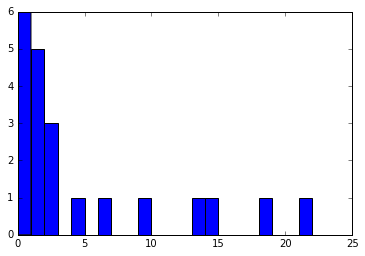

In [527]:
# Check the actual edit distances that will be needed
list_had = list()
distance_list = list()
for ix in range(len(msg_enc)):
    letter_enc = msg_enc[ix]
    letter_dec = msg[ix]

    try:
        if letter_enc not in list_had:
            ordering = all_options_combined.loc[letter_enc].sort_values(ascending=False).reset_index()
            distance = ordering[ordering['index'] == letter_dec.lower()].index[0]
            distance_list += [distance]
            list_had += [letter_enc]
    except (IndexError,KeyError):
        pass
    
print("All edit distances: {}".format(distance_list))
print("Mean edit distances needed: {}".format(np.mean(distance_list)))
plt.hist(distance_list, bins=list(range(26)))
plt.show()

In [528]:
tuple_per_ix_col = [(index, column, value) for index, column_value in all_options_combined.to_dict('index').items() for column, value in column_value.items()]
tuple_per_ix_col_sorted = sorted(tuple_per_ix_col, key=lambda ix_col: ix_col[2], reverse=True)

In [529]:
def generate_best_options(ix_col_value_list, cipher):
    for t in ix_col_value_list:
        # Update cipher with this new choice, and clear the list
        cipher[t[0]] = t[1]
        new_ix_col_value = [x for x in ix_col_value_list if x[0] != t[0] and x[1] != t[1]]
    
        # If the list is not empty, continue. Else, return the cipher.
        if len(new_ix_col_value) > 0:
            done_ciphers = list()
            for cipher_new in generate_best_options(new_ix_col_value, cipher):
                if cipher_new not in done_ciphers:
                    done_ciphers.append(cipher_new)
                    yield cipher_new
        else:
            yield cipher

In [530]:
# Filter out zero values
tuple_per_ix_col_sorted_filtered = [(ix,col,val) for ix,col,val in tuple_per_ix_col_sorted if val > 0]

In [531]:
print('All options: {}'.format(len(tuple_per_ix_col_sorted)))
print('Non zero options: {}'.format(len(tuple_per_ix_col_sorted_filtered)))

All options: 546
Non zero options: 297


In [533]:
# Go find
count = 0

for cipher_option in generate_best_options(tuple_per_ix_col_sorted_filtered, {}):
    count += 1
    
    # Fill cipher with missing keys
    missing_keys = list(character_set)
    for k in cipher_option.keys():
        missing_keys.remove(k)
    for k in missing_keys:
        cipher_option[k] = ''
    
    msg_desc = decipher_text(msg_enc, cipher_option)
    if(is_valid_sentence(msg_desc, 'nl', acceptance_perc=0.8)):
        print('FOUND in : {}'.format(count))
        print(msg_desc)
        break

KeyboardInterrupt: 

In [ ]:
# List options for all the letters in order
ordered_options_dict = dict()
for ix in all_options_combined.index:
    non_zero_options_sorted = all_options_combined.loc[ix][all_options_combined.loc[ix] > 0].sort_values(ascending=False)
    ordered_options_dict[ix] = tuple(non_zero_options_sorted.index)

In [ ]:
ordered_options_dict

In [ ]:
cipher_enc